# **3.5 First steps with TensorFlow**

In [ ]:
import tensorflow as tf

**Listing 3.1 All-ones or all-zeros tensors**

In [ ]:
x = tf.ones(shape=(2, 1))
print(x)

tf.Tensor(
[[1.]
 [1.]], shape=(2, 1), dtype=float32)


In [ ]:
x = tf.zeros(shape=(2,1))
print(x)

tf.Tensor(
[[0.]
 [0.]], shape=(2, 1), dtype=float32)


**Listing 3.2 Random tensors**

In [ ]:
x = tf.random.normal(shape=(3,1), mean=0., stddev=1.)
print(x)

tf.Tensor(
[[ 0.43577817]
 [ 0.14235853]
 [-0.6295156 ]], shape=(3, 1), dtype=float32)


In [ ]:
x = tf.random.uniform(shape=(3,1), minval=0., maxval=1.)
print(x)

tf.Tensor(
[[0.00959218]
 [0.38181138]
 [0.28662324]], shape=(3, 1), dtype=float32)


**Listing 3.3/3.4 NumPy arrays are assignable, TensorFlow tensors are not assignable**


In [ ]:
import numpy as np
x = np.ones(shape=(2,2))
x[0, 0] = 0.

In [ ]:
x = tf.ones(shape=(2, 2))
x[0, 0] = 0.

TypeError: ignored

**Listing 3.5 Creating a TensorFlow variable**

In [ ]:
v = tf.Variable(initial_value=tf.random.normal(shape=(3,1)))
print(v)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[1.7627406 ],
       [0.11782978],
       [0.06732912]], dtype=float32)>


**Listing 3.6 Assigning a value to a TensorFlow variable**

In [ ]:
v.assign(tf.ones((3,1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[1.],
       [1.],
       [1.]], dtype=float32)>

**Listing 3.7 Assigning a value to a subset of a TensorFlow variable**

In [ ]:
v[0,0].assign(3.)

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[3.],
       [1.],
       [1.]], dtype=float32)>

**Listing 3.8 Using assign_add()**

In [ ]:
v.assign_add(tf.ones((3,1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[4.],
       [2.],
       [2.]], dtype=float32)>

**Listing 3.9 A few basic math operations**

In [ ]:
a = tf.ones((2,2))
b = tf.square(a)
c = tf.sqrt(a)
d = b + c
e = tf.matmul(a, b)
e *= d
print(a, b, c, d, e)

tf.Tensor(
[[1. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32) tf.Tensor(
[[1. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32) tf.Tensor(
[[1. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32) tf.Tensor(
[[2. 2.]
 [2. 2.]], shape=(2, 2), dtype=float32) tf.Tensor(
[[4. 4.]
 [4. 4.]], shape=(2, 2), dtype=float32)



**Listing 3.10 Using the GradientTape**

In [ ]:
input_var = tf.Variable(initial_value=3.)
with tf.GradientTape() as tape:
  result = tf.square(input_var)
gradient = tape.gradient(result, input_var)
print(gradient)

tf.Tensor(6.0, shape=(), dtype=float32)


**Listing 3.11 Using GradientTape with constant tensor inputs**

In [ ]:
input_const = tf.constant(3.)
print(input_const)
with tf.GradientTape() as tape:
  tape.watch(input_const)
  result = tf.square(input_const)
gradient = tape.gradient(result, input_const)
print(gradient)

tf.Tensor(3.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)


**Listing 3.12 Using nested gradient tapes to compute second-order gradients**

In [ ]:
time = tf.Variable(0.)
with tf.GradientTape() as outer_tape:
  with tf.GradientTape() as inner_tape:
    position = 4.9 * time ** 2
  speed = inner_tape.gradient(position, time)
  print("speed:", speed)
acceleration = outer_tape.gradient(speed, time)
print("acceleration: ", acceleration)

speed: tf.Tensor(0.0, shape=(), dtype=float32)
acceleration:  tf.Tensor(9.8, shape=(), dtype=float32)


# **3.5.4 An end-to-end example: A linear classifier in pure TensorFlow**

**Creating the variables**

In [ ]:
num_samples_per_class = 1000
negative_samples = np.random.multivariate_normal(
  mean=[0, 3],
  cov=[[1, 0.5],[0.5, 1]],
  size=num_samples_per_class
)
positive_samples = np.random.multivariate_normal(
    mean=[3, 0],
    cov=[[1, 0.5], [0.5,1]],
    size=num_samples_per_class
)
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)
print(inputs)

[[ 1.2524478   2.739178  ]
 [-0.11978709  3.198828  ]
 [ 0.17605731  3.8474085 ]
 ...
 [ 3.3656993   0.8607354 ]
 [ 1.4432776  -0.18888892]
 [ 4.358387    0.754839  ]]


In [ ]:
targets = np.vstack((
    np.zeros((num_samples_per_class, 1), dtype="float32"),
    np.ones((num_samples_per_class, 1), dtype="float32")
))

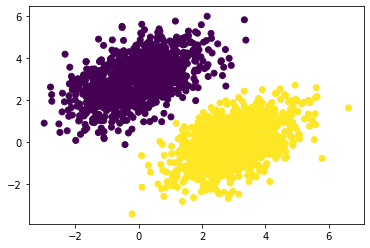

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

In [ ]:
input_dim = 2
output_dim = 1
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

**Listing 3.18 The forward pass function**

In [ ]:
def model(inputs):
  return tf.matmul(inputs, W) + b

**Listing 3.19 The mean squared error loss function**

In [ ]:
def square_loss(targets, predictions):
  per_sample_losses = tf.square(targets - predictions)
  return tf.reduce_mean(per_sample_losses)

**Listing 3.20 The training step function**

In [ ]:
learning_rate = 0.1

def training_step(inputs, targets):
  with tf.GradientTape() as tape:
    predictions = model(inputs)
    loss = square_loss(targets, predictions)
  grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
  W.assign_sub(grad_loss_wrt_W * learning_rate)
  b.assign_sub(grad_loss_wrt_b * learning_rate)
  return loss

**Listing 3.21 The batch training loop**

In [ ]:
for step in range(40):
  loss = training_step(inputs, targets)
  print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 4.4534
Loss at step 1: 0.6086
Loss at step 2: 0.2011
Loss at step 3: 0.1485
Loss at step 4: 0.1336
Loss at step 5: 0.1235
Loss at step 6: 0.1146
Loss at step 7: 0.1066
Loss at step 8: 0.0992
Loss at step 9: 0.0926
Loss at step 10: 0.0865
Loss at step 11: 0.0810
Loss at step 12: 0.0760
Loss at step 13: 0.0714
Loss at step 14: 0.0672
Loss at step 15: 0.0634
Loss at step 16: 0.0600
Loss at step 17: 0.0568
Loss at step 18: 0.0540
Loss at step 19: 0.0514
Loss at step 20: 0.0490
Loss at step 21: 0.0468
Loss at step 22: 0.0449
Loss at step 23: 0.0431
Loss at step 24: 0.0415
Loss at step 25: 0.0400
Loss at step 26: 0.0386
Loss at step 27: 0.0374
Loss at step 28: 0.0363
Loss at step 29: 0.0352
Loss at step 30: 0.0343
Loss at step 31: 0.0335
Loss at step 32: 0.0327
Loss at step 33: 0.0320
Loss at step 34: 0.0314
Loss at step 35: 0.0308
Loss at step 36: 0.0302
Loss at step 37: 0.0298
Loss at step 38: 0.0293
Loss at step 39: 0.0289


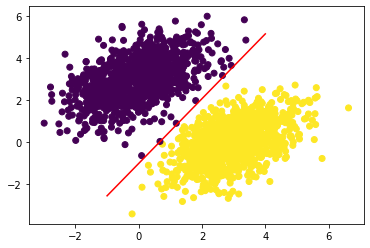

In [ ]:
predictions = model(inputs)
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
x = np.linspace(-1, 4, 100)
y=-W[0]/ W[1]*x+(0.5-b)/W[1]
plt.plot(x, y, "-r")
plt.show()